In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import os
import pathlib
import scipy.linalg
import scipy.interpolate
import meshio
import gmsh
import matplotlib.pyplot as plt
import pytictoc

from femns2d import femns2d

In [3]:
def create_unit_square_mesh(pfactor=0.1, name="unit_square.msh"):
    gmsh.initialize()
    gmsh.model.add('unit_square')
    
    # Create points for unit square corners
    gmsh.model.geo.addPoint(0, 0, 0, pfactor, 1)
    gmsh.model.geo.addPoint(1, 0, 0, pfactor, 2)
    gmsh.model.geo.addPoint(1, 1, 0, pfactor, 3)
    gmsh.model.geo.addPoint(0, 1, 0, pfactor, 4)

    # Connect points with lines to form unit square
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)

    # Create Curve Loop and Plane Surface
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)

    # Add physical lines for the boundaries
    gmsh.model.geo.addPhysicalGroup(1, [1], 1)
    gmsh.model.geo.addPhysicalGroup(1, [2], 2)
    gmsh.model.geo.addPhysicalGroup(1, [3], 3)
    gmsh.model.geo.addPhysicalGroup(1, [4], 4)    
    # Add physical group for the surface
    gmsh.model.geo.addPhysicalGroup(2, [1], 5)

    # Synchronize model and define mesh size
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)

    # Save mesh
    gmsh.write('unit_square.msh')

    gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000412559s, CPU 0.00043s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00542253s, CPU 0.004872s)
Info    : 142 nodes 286 elements
Info    : Writing 'unit_square.msh'...
Info    : Done writing 'unit_square.msh'



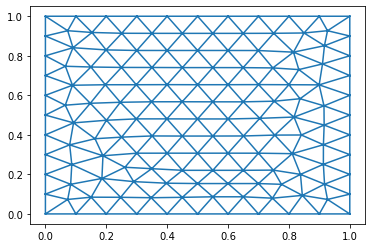

In [4]:
# Read the mesh file
create_unit_square_mesh(0.1)
mesh = meshio.read("unit_square.msh")

# Plot the mesh
fig, ax = plt.subplots()
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

plt.show()

The equation

$$
\frac{\partial \mu}{\partial t} - \nabla \cdot (D \nabla \mu) - D \nabla \mu \cdot \nabla \mu = 0
$$

In [5]:
dt = 0.01
steps = 100
dirichlet_bcs = [[1], [3]]

In [8]:
def diffusion_function(xy):
    x = xy[..., 0]
    y = xy[..., 1]
    condition = (x > 0.25) & (x < 0.75)
    diff = 0.1*condition + 1.0*(1-condition)
    return diff
assembler = femns2d.MiniAssembler(mesh)
element_diffusions = diffusion_function(assembler.centroids)
nonlinear_factor = 10.0

In [9]:
assembler = femns2d.MiniAssembler(mesh)
assembler.set_main_element("linear")
K = assembler.stiffness_matrix(stiffness_fn=lambda i : element_diffusions[i],
                               stiffness_fn_type='element')
M = assembler.mass_matrix()
mu = np.zeros(assembler.npoints)
mu = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, mu, where='u')
mu_list = [mu.copy()]
for step in range(steps):
    gradmu = assembler.get_linear_element_equation(mu)[:, :-1]
    G = assembler.convection_matrix(lambda i :-element_diffusions[i]*gradmu[i], velocity_fn_type='element')
    A = M/dt + K + nonlinear_factor*G
    A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs[1], A, where='u')
    f = M/dt@mu
    f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, f, where='u')
    mu = scipy.sparse.linalg.spsolve(A.tocsc(), f)
    mu_list.append(mu.copy())
    print(step)
    
#     if 
# MKdt = M + dt*K
# MKdt = assembler.apply_dirichlet_to_matrix(dirichlet_bcs[1], MKdt, where='u', data_dict_name="grain")

# Tvalues = []
# T = np.zeros(assembler.nvariables)
# T = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, T, where='u', data_dict_name="grain")
# Tvalues.append(T.copy())

# MKdt = MKdt.tocsc()
# LU = scipy.sparse.linalg.splu(MKdt)

# for i in range(steps):
#     f = M@T
#     f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, f, where='u', data_dict_name="grain")
#     MKdt = MKdt.tocsc()
#     T = LU.solve(f)
#     Tvalues.append(T.copy())
# T = np.array(Tvalues)
# t = np.arange(steps)*dt

# return T, t

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


KeyboardInterrupt: 

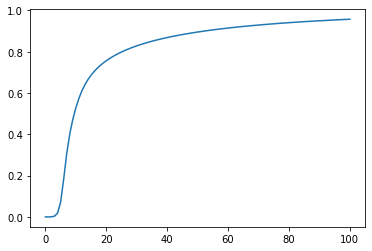

In [311]:
plt.plot([mu[y == 0].mean() for mu in mu_list])

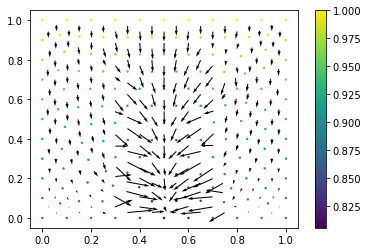

In [312]:
frame = 40
mu = mu_list[frame]
gradmu = assembler.get_linear_element_equation(mu)[:, :-1]
x, y = assembler.points[:, 0], assembler.points[:, 1]
plt.scatter(x, y, c=mu, s=2)
plt.colorbar()
xe, ye = assembler.centroids[..., 0], assembler.centroids[..., 1]
plt.quiver(xe, ye, -gradmu[..., 0], -gradmu[..., 1])

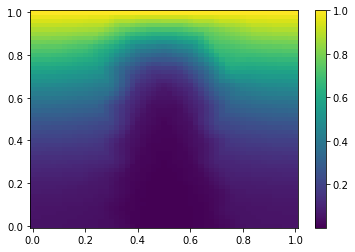

In [308]:
frame = 10
mu = mu_list[frame]
mu_interp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], mu)

ngrid = 51
xplot, yplot = np.linspace(0, 1, ngrid), np.linspace(0, 1, ngrid)
Xplot, Yplot = np.meshgrid(xplot, yplot)
Mu = mu_interp(X, Y)
plt.pcolormesh(X, Y, Mu, shading='auto')
plt.colorbar()